# Labelling Recipes Stage
**Sharon Marfatia**

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
fifty_cutoff = 191.12
# is the overall baseline supposed to be the GHG_baseline?
overall_baseline = 382.25

GHG_baseline = 382.25
nitrogen_baseline = 3.86
water_baseline = 1248.19
land_baseline = 0.93

In [3]:
# CHANGE THIS AS NEEDED:
restaurant_name = "AMS_Gallery23-24"
# restaurant_name = "OK23-24"
# restaurant_name = "Gather23-24"
# restaurant_name = "Totem23-24"

In [4]:
def create_ghg_label(label):
    # determine the GHG label based on the given label value and predefined cutoffs
    if label > overall_baseline:
        # if the label value is > than overall baseline, assign "Red" label
        return "Red"
    elif (label <= overall_baseline) & (label > fifty_cutoff):
        # if the label value is between overall baseline and fifty_cutoff, assign "Yellow" label
        return "Yellow"
    elif label <= fifty_cutoff:
        # if the label value is less than or equal to the fifty_cutoff, assign "Green" label
        return "Green"


In [5]:
def create_results_all_factors(df):
    # create a Combined Label based on different factors for each row in the DataFrame
    df["Combined Label"] = ""

    # add another parameter: n so that change the number of factors instead of multiplying by 3

    def calculate_all_factors(ghg, nitrogen, water, land):
        # calculate the combined label value based on the given factors
        weighted_ghg = ghg / (4 * GHG_baseline)
        weighted_nitrogen = nitrogen / (4 * nitrogen_baseline)
        weighted_water = water / (4 * water_baseline)

        # most recently added
        weighted_land = land / (4 * land_baseline)

        return weighted_ghg + weighted_nitrogen + weighted_water + weighted_land


    for ind, row in df.iterrows():
        # iterate over each row in the DataFrame and calculate the combined label
        label = calculate_all_factors(row["GHG Emission (g) / 100g"], row["N lost (g) / 100g"],
                                      row["Stress-Weighted Water Use (L) / 100g"],
                                      row['Land Use (m^2) / 100g'])

        if label <= 0.5:
            # if the label value is less than or equal to 0.5, assign "Green" label
            df.loc[ind, "Combined Label"] = "Green"
        elif label >= 1:
            # if the label value is greater than or equal to 1, assign "Red" label
            df.loc[ind, "Combined Label"] = "Red"
        elif (label > 0.5) or (label < 1):
            # if the label value is between 0.5 and 1, assign "Yellow" label
            df.loc[ind, "Combined Label"] = "Yellow"
    return df


In [6]:
# Sharon: Updated function Nov 21 2023
# Fixes KeyError: 1
def add_menu_names(df, mapping_dict):
    # Add menu names to the DataFrame based on a dictionary
    df["Displayed Name"] = ""
    menu_name = list(mapping_dict.keys())
    menu_ID = list(mapping_dict.values())
    for ind, row in df.iterrows():
        searchID = row["ProdId"]
        if searchID in menu_ID:
            position = menu_ID.index(searchID)
            name = menu_name[position]
            df.at[ind, "Displayed Name"] = name

    name_col = df.pop("Displayed Name")
    df.insert(0, "Displayed Name", name_col)
    df = df.dropna(subset=["Displayed Name"])

    df_temp = df["Displayed Name"].str.split("|", expand=True)
    df["Category"] = df_temp[0]

    # Ensure that 'Displayed Name' is updated only if there is a second column
    if len(df_temp.columns) > 1:
        df["Displayed Name"] = df_temp[1]
    else:
        df["Displayed Name"] = ""

    name_col2 = df.pop("Category")
    df.insert(0, "Category", name_col2)
    return df



# def add_menu_names(df, dict):
#     # add menu names to the DataFrame based on a dictionary
#     df["Displayed Name"] = ""
#     menu_name = list(dict.keys())
#     menu_ID = list(dict.values())
#     for ind, row in df.iterrows():
#         searchID = row["ProdId"]
#         if searchID in menu_ID:
#             # if the product ID is found in the menu_ID list, retrieve the corresponding name
#             position = menu_ID.index(searchID)
#             name = menu_name[position]
#             df.loc[ind, "Displayed Name"] = name
#         else:
#             continue
#     name_col = df.pop("Displayed Name")
#     df.insert(0, "Displayed Name", name_col)
#     df = df.dropna(subset=["Displayed Name"])

#     df_temp = df["Displayed Name"].str.split("|", expand=True)
#     df["Category"] = df_temp[0]
#     df["Displayed Name"] = df_temp[1]
#     name_col2 = df.pop("Category")
#     df.insert(0, "Category", name_col2)
#     # returns the modified DataFrame with the added "Category" and "Displayed Name" columns
#     return df


In [7]:
def create_final_counts(df):
    # create final counts of GHG and combined labels from DataFrame

    # count the occurrences of GHG Only labels
    ghg_red = df["GHG Only Label"].value_counts()["Red"]
    ghg_yellow = df["GHG Only Label"].value_counts()["Yellow"]
    ghg_green = df["GHG Only Label"].value_counts()["Green"]
    # count the occurrences of Combined labels
    all_red = df["Combined Label"].value_counts()["Red"]
    all_yellow = df["Combined Label"].value_counts()["Yellow"]
    all_green = df["Combined Label"].value_counts()["Green"]
    print(all_red, all_yellow, all_green)
    # create a dictionary to store the label counts
    data = {"GHG Label Counts": [ghg_red, ghg_yellow, ghg_green],
            "Combined Label Counts": [all_red, all_yellow, all_green]}
    # create a DataFrame from the label counts data and return it
    results = pd.DataFrame(data, index=["Red", "Yellow", "Green"])
    return results


In [8]:
def create_visualizations(df):
    df.reset_index(inplace=True)
    df = df.rename(columns={"index": "Color"})
    sns.set_theme(style="darkgrid")
    palette = {"Green": "tab:green", "Red": "tab:red", "Yellow": "tab:orange", "Sum": "tab:blue"}
    fig, axes = plt.subplots(1, 2, figsize=(7, 4), sharex=False, sharey=True)
    fig.suptitle("Emission Label Counts")
    ax1 = sns.barplot(data=df, x=df["Color"], y=df["GHG Label Counts"], ax=axes[0], palette=palette)
    ax1.set_title("GHG Emission Label")
    ax1.set_ylabel("Counts")
    ax1.set_xlabel("")
    ax2 = sns.barplot(data=df, x=df["Color"], y=df["Combined Label Counts"], ax=axes[1], palette=palette)
    ax2.set_title("Combined Emissions Label")
    ax2.set_ylabel("")
    ax2.set_xlabel("")
    fig.title = "Color Comparison"
    ax1.set_title = "GHG Emission Label Counts"
    ax2.set_title = "Combined Emissions Label Counts"
    ax2.set_ylabel = ""
    for ax in [ax1, ax2]:
        for i in ax.containers:
            ax.bar_label(i, )
    plt.tight_layout()
    plt.savefig("C:/Users/smvan/CFFS-S23/CFFS-22-23/data/final/2023_2024_CFFS_Outcomes/Summary_fig.png")
    plt.show()

In [9]:
def create_category_true(df):
    # create category columns for True values in the DataFrame

    # create empty columns for each category
    df["RED"] = ""
    df["YELLOW"] = ""
    df["GREEN"] = ""
    # iterate over each row in the DataFrame
    for ind, row in df.iterrows():
        # Check the value of the Combined Label column and assign "TRUE" to the corresponding category column
        if row["Combined Label"] == "Red":
            df.loc[ind, "RED"] = "TRUE"
        if row["Combined Label"] == "Yellow":
            df.loc[ind, "YELLOW"] = "TRUE"
        if row["Combined Label"] == "Green":
            df.loc[ind, "GREEN"] = "TRUE"
    # adds category columns for True values based on the Combined Label column
    return df


In [10]:
products = pd.read_csv('C:/Users/smvan/CFFS-S23/CFFS-22-23/data/preprocessed/AMS_data/Products_List.csv')

In [11]:
final = products.copy()
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,P-15019,Butter Chicken Prep 2023,N,382.007004,747.809619,6.262882,1.387041,84.68,4072.17,195.76,1.64,22.17,1065.99,0.36
1,P-18296,Teriyaki Tempeh Prep 2023,N,384.350600,753.378731,2.076100,2.280273,12.05,645.00,196.01,0.54,3.14,167.82,0.59
2,P-17366,Chicken Teriyaki Prep 2023,Y,385.670500,1195.981859,20.921744,3.529265,66.63,177.91,310.10,5.42,17.28,46.13,0.92
3,P-18330,Tuscan Prep 2023,N,298.012999,658.621680,6.419223,1.204808,115.96,5196.26,221.00,2.15,38.91,1743.64,0.40
4,P-14560,2022 Caesar Wrap prep,N,415.597292,729.603111,8.914526,1.666274,123.20,4939.94,175.56,2.14,29.64,1188.64,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,R-18272,Truffle Mushroom Pasta 2023,N,342.824999,1539.977637,8.291102,2.927251,84.69,5556.78,449.20,2.42,24.70,1620.88,0.85
297,R-15427,Vegan Chipotle Mayo,N,1150.000000,9370.300000,7.762500,31.000000,27.93,390.54,814.81,0.68,2.43,33.96,2.70
298,R-15426,Vegan Tofu Scramble,N,50.280000,48.810812,0.339712,0.087333,2.22,18.30,97.08,0.68,4.42,36.40,0.17
299,R-15544,VEGGIE BENNY,N,225.000000,342.127000,1.802500,1.816600,21.78,678.34,152.06,0.80,9.68,301.48,0.81


In [12]:
final["GHG Only Label"] = final["GHG Emission (g) / 100g"].apply(lambda x: create_ghg_label(x))
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label
0,P-15019,Butter Chicken Prep 2023,N,382.007004,747.809619,6.262882,1.387041,84.68,4072.17,195.76,1.64,22.17,1065.99,0.36,Yellow
1,P-18296,Teriyaki Tempeh Prep 2023,N,384.350600,753.378731,2.076100,2.280273,12.05,645.00,196.01,0.54,3.14,167.82,0.59,Yellow
2,P-17366,Chicken Teriyaki Prep 2023,Y,385.670500,1195.981859,20.921744,3.529265,66.63,177.91,310.10,5.42,17.28,46.13,0.92,Yellow
3,P-18330,Tuscan Prep 2023,N,298.012999,658.621680,6.419223,1.204808,115.96,5196.26,221.00,2.15,38.91,1743.64,0.40,Yellow
4,P-14560,2022 Caesar Wrap prep,N,415.597292,729.603111,8.914526,1.666274,123.20,4939.94,175.56,2.14,29.64,1188.64,0.40,Green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,R-18272,Truffle Mushroom Pasta 2023,N,342.824999,1539.977637,8.291102,2.927251,84.69,5556.78,449.20,2.42,24.70,1620.88,0.85,Red
297,R-15427,Vegan Chipotle Mayo,N,1150.000000,9370.300000,7.762500,31.000000,27.93,390.54,814.81,0.68,2.43,33.96,2.70,Red
298,R-15426,Vegan Tofu Scramble,N,50.280000,48.810812,0.339712,0.087333,2.22,18.30,97.08,0.68,4.42,36.40,0.17,Green
299,R-15544,VEGGIE BENNY,N,225.000000,342.127000,1.802500,1.816600,21.78,678.34,152.06,0.80,9.68,301.48,0.81,Green


In [13]:
final = create_results_all_factors(final)
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label,Combined Label
0,P-15019,Butter Chicken Prep 2023,N,382.007004,747.809619,6.262882,1.387041,84.68,4072.17,195.76,1.64,22.17,1065.99,0.36,Yellow,Yellow
1,P-18296,Teriyaki Tempeh Prep 2023,N,384.350600,753.378731,2.076100,2.280273,12.05,645.00,196.01,0.54,3.14,167.82,0.59,Yellow,Green
2,P-17366,Chicken Teriyaki Prep 2023,Y,385.670500,1195.981859,20.921744,3.529265,66.63,177.91,310.10,5.42,17.28,46.13,0.92,Yellow,Yellow
3,P-18330,Tuscan Prep 2023,N,298.012999,658.621680,6.419223,1.204808,115.96,5196.26,221.00,2.15,38.91,1743.64,0.40,Yellow,Yellow
4,P-14560,2022 Caesar Wrap prep,N,415.597292,729.603111,8.914526,1.666274,123.20,4939.94,175.56,2.14,29.64,1188.64,0.40,Green,Yellow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,R-18272,Truffle Mushroom Pasta 2023,N,342.824999,1539.977637,8.291102,2.927251,84.69,5556.78,449.20,2.42,24.70,1620.88,0.85,Red,Red
297,R-15427,Vegan Chipotle Mayo,N,1150.000000,9370.300000,7.762500,31.000000,27.93,390.54,814.81,0.68,2.43,33.96,2.70,Red,Red
298,R-15426,Vegan Tofu Scramble,N,50.280000,48.810812,0.339712,0.087333,2.22,18.30,97.08,0.68,4.42,36.40,0.17,Green,Green
299,R-15544,VEGGIE BENNY,N,225.000000,342.127000,1.802500,1.816600,21.78,678.34,152.06,0.80,9.68,301.48,0.81,Green,Green


In [14]:
final.to_csv("C:/Users/smvan/CFFS-S23/CFFS-22-23/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+".csv", 
             index=False)
final.to_excel("C:/Users/smvan/CFFS-S23/CFFS-22-23/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+".xlsx", 
               sheet_name="Labels", index=False)

In [15]:
# CHANGE THE NAME AS NEEDED AS PER THE RESTAURANT:

OK_list = final.set_index('Description')['ProdId'].to_dict()
OK_list

{'Butter Chicken Prep 2023 ': 'P-15019',
 'Teriyaki Tempeh Prep 2023': 'P-18296',
 'Chicken Teriyaki Prep 2023': 'P-17366',
 'Tuscan Prep 2023': 'P-18330',
 '2022 Caesar Wrap prep': 'P-14560',
 '2022 Power Punch Salad prep': 'P-15006',
 'KFC Gallery prep 2022': 'P-18266',
 'Beets salad prep 2023 ': 'P-18275',
 'Yam Fries prep 2023': 'P-18313',
 'Crispy EggPlant prep 2023': 'P-18316',
 ' 2022 goose & Watermelon bull': 'R-17284',
 ' Vegan Caesar wrap 2022': 'R-18292',
 '"Pulled Pork" Sliders': 'R-15423',
 '2019 Chipotle Aioli': 'R-6243',
 '2019 Falafel Edamame': 'R-13758',
 '2019 Ginger Garlic Paste': 'R-13736',
 '2019 Makhni Sauce': 'R-13737',
 '2019 Organic Quinoa': 'R-13747',
 '2022  BUTTERMILK TENDERS': 'R-14906',
 '2022  Candied Pecans Batch': 'R-12613',
 '2022  Extreme Nachos': 'R-16573',
 '2022  FISH TACO': 'R-15511',
 '2022 ADD ON 1 pcs fish ': 'R-10484',
 '2022 Aglio e Olio (Chicken)': 'R-17356',
 '2022 Ancho Tempeh marinade': 'R-16570',
 '2022 Ancho Tempeh Taco': 'R-16576',
 '2

In [16]:
final2 = final.copy()
final2 = add_menu_names(final, OK_list)
final2.to_csv("C:/Users/smvan/CFFS-S23/CFFS-22-23/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.csv",
                  index=False)
final2.to_csv("C:/Users/smvan/CFFS-S23/CFFS-22-23/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.xlsx",
                  index=False)

In [17]:
# # # ADDED FOR GATHER:
# final2 = pd.read_csv("C:/Users/smvan/CFFS-S23/CFFS-22-23/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.csv")
# final2.head()

In [18]:
counts = create_final_counts(final2)
all_ghg_num = counts["GHG Label Counts"].sum()
all_num = counts["Combined Label Counts"].sum()
sum_row = pd.Series(data={"GHG Label Counts": all_ghg_num, "Combined Label Counts": all_num}, name="Sum")

77 69 152


In [19]:
counts = counts.append(sum_row, ignore_index=False)
counts.to_csv("C:/Users/smvan/CFFS-S23/CFFS-22-23/data/final/2023_2024_CFFS_Outcomes/"+restaurant_name+"_Summary.csv", index=False)
counts_print = pd.concat([counts, sum_row], ignore_index=True)
counts


# THERE ARE 5 SUM ROWS BECUASE THERE ARE 5 EMISSION FACTORS THAT WE ARE LOOKING AT: GHG, nitrogen, stressed water, fresh water
# and land use

C:\Users\smvan\AppData\Local\Temp\ipykernel_12304\3944149530.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts = counts.append(sum_row, ignore_index=False)


,GHG Label Counts,Combined Label Counts
Red,76,77
Yellow,71,69
Green,151,152
Sum,298,298


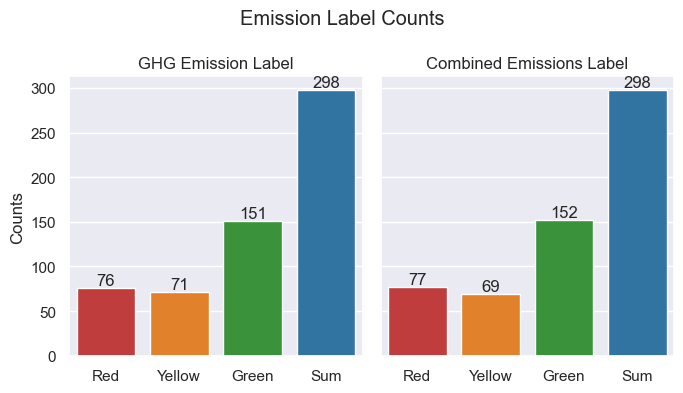

In [20]:
# THE BLUE BAR REPRESENTS THE SUM ROW WHICH IS THE TOTAL NUMBER OF RECIPES THAT HAVE BEEN ASSIGNED A LABEL
# EACH BAR REPRESENTS THE # OF RECIPES THAT WERE LABELLED WITH THAT SPECIFIC COLOUR

fig = create_visualizations(counts)
fig

In [21]:
final2.head()

,Category,Displayed Name,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label,Combined Label
0,Butter Chicken Prep 2023,,P-15019,Butter Chicken Prep 2023,N,382.007004,747.809619,6.262882,1.387041,84.68,4072.17,195.76,1.64,22.17,1065.99,0.36,Yellow,Yellow
1,Teriyaki Tempeh Prep 2023,,P-18296,Teriyaki Tempeh Prep 2023,N,384.350600,753.378731,2.076100,2.280273,12.05,645.00,196.01,0.54,3.14,167.82,0.59,Yellow,Green
2,Chicken Teriyaki Prep 2023,,P-17366,Chicken Teriyaki Prep 2023,Y,385.670500,1195.981859,20.921744,3.529265,66.63,177.91,310.10,5.42,17.28,46.13,0.92,Yellow,Yellow
3,Tuscan Prep 2023,,P-18330,Tuscan Prep 2023,N,298.012999,658.621680,6.419223,1.204808,115.96,5196.26,221.00,2.15,38.91,1743.64,0.40,Yellow,Yellow
4,2022 Caesar Wrap prep,,P-14560,2022 Caesar Wrap prep,N,415.597292,729.603111,8.914526,1.666274,123.20,4939.94,175.56,2.14,29.64,1188.64,0.40,Green,Yellow


In [22]:
final3 = final2.drop(columns=['Category', 'Displayed Name', 'Weight (g)', 'GHG Only Label'])

In [23]:
final3.head()

,ProdId,Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label
0,P-15019,Butter Chicken Prep 2023,N,747.809619,6.262882,1.387041,84.68,4072.17,195.76,1.64,22.17,1065.99,0.36,Yellow
1,P-18296,Teriyaki Tempeh Prep 2023,N,753.378731,2.076100,2.280273,12.05,645.00,196.01,0.54,3.14,167.82,0.59,Green
2,P-17366,Chicken Teriyaki Prep 2023,Y,1195.981859,20.921744,3.529265,66.63,177.91,310.10,5.42,17.28,46.13,0.92,Yellow
3,P-18330,Tuscan Prep 2023,N,658.621680,6.419223,1.204808,115.96,5196.26,221.00,2.15,38.91,1743.64,0.40,Yellow
4,P-14560,2022 Caesar Wrap prep,N,729.603111,8.914526,1.666274,123.20,4939.94,175.56,2.14,29.64,1188.64,0.40,Yellow


In [24]:
final3.rename(columns={'ProdId': 'Optimum Control ID', 'Description': 'OC Description'}, inplace=True)

In [25]:
final3.head()

,Optimum Control ID,OC Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label
0,P-15019,Butter Chicken Prep 2023,N,747.809619,6.262882,1.387041,84.68,4072.17,195.76,1.64,22.17,1065.99,0.36,Yellow
1,P-18296,Teriyaki Tempeh Prep 2023,N,753.378731,2.076100,2.280273,12.05,645.00,196.01,0.54,3.14,167.82,0.59,Green
2,P-17366,Chicken Teriyaki Prep 2023,Y,1195.981859,20.921744,3.529265,66.63,177.91,310.10,5.42,17.28,46.13,0.92,Yellow
3,P-18330,Tuscan Prep 2023,N,658.621680,6.419223,1.204808,115.96,5196.26,221.00,2.15,38.91,1743.64,0.40,Yellow
4,P-14560,2022 Caesar Wrap prep,N,729.603111,8.914526,1.666274,123.20,4939.94,175.56,2.14,29.64,1188.64,0.40,Yellow


In [26]:
final3['Red'] = final3['Combined Label'] == 'Red'
final3['Yellow'] = final3['Combined Label'] == 'Yellow'
final3['Green'] = final3['Combined Label'] == 'Green'

In [27]:
final3.head()

,Optimum Control ID,OC Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label,Red,Yellow,Green
0,P-15019,Butter Chicken Prep 2023,N,747.809619,6.262882,1.387041,84.68,4072.17,195.76,1.64,22.17,1065.99,0.36,Yellow,False,True,False
1,P-18296,Teriyaki Tempeh Prep 2023,N,753.378731,2.076100,2.280273,12.05,645.00,196.01,0.54,3.14,167.82,0.59,Green,False,False,True
2,P-17366,Chicken Teriyaki Prep 2023,Y,1195.981859,20.921744,3.529265,66.63,177.91,310.10,5.42,17.28,46.13,0.92,Yellow,False,True,False
3,P-18330,Tuscan Prep 2023,N,658.621680,6.419223,1.204808,115.96,5196.26,221.00,2.15,38.91,1743.64,0.40,Yellow,False,True,False
4,P-14560,2022 Caesar Wrap prep,N,729.603111,8.914526,1.666274,123.20,4939.94,175.56,2.14,29.64,1188.64,0.40,Yellow,False,True,False


In [28]:
import pandas as pd


desired_column_order = [
    'Optimum Control ID', 'OC Description', 'SalesGroup', 'Combined Label', 'Red', 'Yellow', 'Green',
    'GHG Emission (g)', 'N lost (g)', 'Land Use (m^2)', 'Freshwater Withdrawals (L)', 
    'Stress-Weighted Water Use (L)', 'GHG Emission (g) / 100g', 'N lost (g) / 100g', 
    'Freshwater Withdrawals (L) / 100g', 'Stress-Weighted Water Use (L) / 100g', 
    'Land Use (m^2) / 100g'
]

# Create a new DataFrame with the desired column order
data_reordered = final3[desired_column_order]

# Print the reordered DataFrame
data_reordered.head()


,Optimum Control ID,OC Description,SalesGroup,Combined Label,Red,Yellow,Green,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,P-15019,Butter Chicken Prep 2023,N,Yellow,False,True,False,747.809619,6.262882,1.387041,84.68,4072.17,195.76,1.64,22.17,1065.99,0.36
1,P-18296,Teriyaki Tempeh Prep 2023,N,Green,False,False,True,753.378731,2.076100,2.280273,12.05,645.00,196.01,0.54,3.14,167.82,0.59
2,P-17366,Chicken Teriyaki Prep 2023,Y,Yellow,False,True,False,1195.981859,20.921744,3.529265,66.63,177.91,310.10,5.42,17.28,46.13,0.92
3,P-18330,Tuscan Prep 2023,N,Yellow,False,True,False,658.621680,6.419223,1.204808,115.96,5196.26,221.00,2.15,38.91,1743.64,0.40
4,P-14560,2022 Caesar Wrap prep,N,Yellow,False,True,False,729.603111,8.914526,1.666274,123.20,4939.94,175.56,2.14,29.64,1188.64,0.40


In [29]:
data_reordered.to_csv("C:/Users/smvan/CFFS-S23/CFFS-22-23/data/final/2023_2024_CFFS_Outcomes/Labelled_Data_"+restaurant_name+"_for_nutrislice.csv",
                  index=False)